# SWIN Transformer Fine Tuning Overview

This notebook involves training a Swin Transformer model on the TinyImageNet dataset. Here's a breakdown of its activities:

1. **Data Acquisition and Preparation**:
    - Downloads the TinyImageNet dataset using `wget`.
    - Unzips the dataset for further usage.

2. **Model Initialization**:
    - Loads a pretrained Swin Transformer model.
    - Configures the model to use CUDA if it's available, otherwise it falls back to CPU.
    - Adjusts the final layer of the model to match the number of classes present in the TinyImageNet dataset.

3. **Training Setup**:
    - Uses the Adam optimizer with a learning rate of 0.0001 for fine-tuning.
    - Defines the loss function as CrossEntropyLoss.
    - Creates an `accuracy` function to calculate the accuracy of model predictions against actual labels.

4. **Training Loop**:
    - Uses Mixed Precision Training with a GradScaler.
    - Contains a loop that runs for a predefined number of epochs (8 epochs in this case). Each epoch consists of:
        - **Training Phase**: Model is set to training mode, and weights are updated using the training dataset.
        - **Validation Phase**: Model is set to evaluation mode to assess its performance on the test dataset.
    - Calculates and logs average loss and accuracy metrics for both training and validation phases.
    - Progress bars (`tqdm`) are used to provide visual feedback on the training and validation processes.

5. **Results Visualization**:
    - Plots the training and validation losses and accuracies over time (epochs) using matplotlib. This helps in understanding the model's performance and potential overfitting or underfitting trends.

In summary, this notebook is designed to fine-tune a Swin Transformer model on the TinyImageNet dataset, leveraging mixed precision training for efficiency. At the end of the training, it visualizes the training dynamics to help assess the model's learning curve.

## Data Acquisition

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -o -qq tiny-imagenet-200.zip


--2023-11-17 03:12:29--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  7.88MB/s    in 47s     

2023-11-17 03:13:16 (5.03 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



## Dependencies

In [2]:
%%capture
# Install necessary libraries
!pip install torch torchvision matplotlib numpy tqdm


# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image




In [3]:
class TinyImageNet(torchvision.datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(TinyImageNet, self).__init__(root, transform=transform, target_transform=target_transform)
        self.split = split
        self.data = []
        self.targets = []
        self.classes = []
        self.class_to_idx = {}

        if self.split == 'train':
            for dir in os.listdir(os.path.join(self.root, self.split)):
                class_path = os.path.join(self.root, self.split, dir, 'images')
                self.classes.append(dir)
                for img_name in os.listdir(class_path):
                    file_path = os.path.join(class_path, img_name)
                    self.data.append(file_path)
                    self.targets.append(dir)

            # Creating the class_to_idx dictionary
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        elif self.split == 'val':
            img_path = os.path.join(self.root, self.split, 'images')
            with open(os.path.join(self.root, self.split, 'val_annotations.txt'), 'r') as f:
                for line in f:
                    split_line = line.split('\t')
                    self.data.append(os.path.join(img_path, split_line[0]))
                    self.targets.append(split_line[1])

            # Since classes for validation are same as training, you can set class_to_idx as trainset's
            self.class_to_idx = trainset.class_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert('RGB')
        target = self.class_to_idx[self.targets[idx]]  # Convert string label to index

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            target = self.target_transform(target)

        return img, target


## Data Loading

In [4]:
import torchvision.transforms as transforms

batch_size = 64  # Reduced from 128
num_workers = 4  # Increased from 2 for faster data loading

# Define the transforms for TinyImageNet to be compatible with Swin Transformer
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Resizing to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(232),  # Resize and then crop to match Swin's requirements
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root_dir = "./tiny-imagenet-200"
trainset = TinyImageNet(root=root_dir, split='train', transform=transform_train)

# Use this block to create a subset of the trainset
from torch.utils.data import Subset
import numpy as np

subset_percent = .1  # 100% in this example
subset_size = int(len(trainset) * subset_percent)
subset_indices = np.random.choice(len(trainset), subset_size, replace=False)
train_subset = Subset(trainset, subset_indices)

# Create DataLoader using the subset
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = TinyImageNet(root=root_dir, split='val', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

classes = list(trainset.class_to_idx.keys())
print("number of classes: ", len(classes))


number of classes:  200


## swin_t model definition

In [5]:
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained Swin Transformer model
model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1, progress=True)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define an MLP with 2 or 3 layers
hidden_dim1 = 512  # You can adjust this
hidden_dim2 = 256  # You can adjust this

mlp_head = nn.Sequential(
    nn.Linear(model.head.in_features, hidden_dim1),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(hidden_dim1, hidden_dim2),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(hidden_dim2, len(classes))
).to(device)

# Update the classifier head to the new MLP
model.head = mlp_head


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:02<00:00, 47.2MB/s]


## Optimizer & Loss

In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Smaller learning rate for fine-tuning
criterion = nn.CrossEntropyLoss()

def accuracy(predictions, labels):
    _, preds = torch.max(predictions, 1)
    return (preds == labels).float().mean().item()

## Training Loop

In [7]:
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

scaler = GradScaler()  # Initialize the GradScaler

num_epochs = 10
train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = 0.0, 0.0, 0.0, 0.0

    # Training Phase
    model.train()
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1} TRAIN", ncols=100)
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        train_acc += accuracy(outputs, labels)

        # Update the progress bar description
        pbar.set_description(f"Epoch {epoch+1} TRAIN Loss: {loss.item():.4f}")

    # Validation Phase
    model.eval()
    pbar = tqdm(enumerate(testloader), total=len(testloader), desc=f"Epoch {epoch+1} VAL", ncols=100)
    with torch.no_grad():
        for i, data in pbar:
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += accuracy(outputs, labels)

            # Update the progress bar description
            pbar.set_description(f"Epoch {epoch+1} VAL Loss: {loss.item():.4f}")

    train_loss /= len(trainloader)
    train_acc /= len(trainloader)
    val_loss /= len(testloader)
    val_acc /= len(testloader)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)



    print(f"Epoch Summary {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    print('-' * 60)

print('Finished Training')


Epoch 1 VAL Loss: 5.1443: 100%|███████████████████████████████████| 157/157 [00:23<00:00,  6.58it/s]

Epoch Summary 1/10
Train Loss: 5.2476, Train Acc: 1.30%, Val Loss: 4.9963, Val Acc: 4.37%
------------------------------------------------------------



Epoch 2 VAL Loss: 3.2716: 100%|███████████████████████████████████| 157/157 [00:24<00:00,  6.50it/s]

Epoch Summary 2/10
Train Loss: 4.5885, Train Acc: 7.73%, Val Loss: 3.5764, Val Acc: 22.59%
------------------------------------------------------------



Epoch 3 VAL Loss: 2.0895: 100%|███████████████████████████████████| 157/157 [00:24<00:00,  6.45it/s]

Epoch Summary 3/10
Train Loss: 3.5464, Train Acc: 23.02%, Val Loss: 2.3655, Val Acc: 46.14%
------------------------------------------------------------



Epoch 4 VAL Loss: 1.6891: 100%|███████████████████████████████████| 157/157 [00:24<00:00,  6.42it/s]

Epoch Summary 4/10
Train Loss: 2.8531, Train Acc: 36.81%, Val Loss: 1.7807, Val Acc: 57.54%
------------------------------------------------------------



Epoch 5 VAL Loss: 2.0892: 100%|███████████████████████████████████| 157/157 [00:24<00:00,  6.41it/s]

Epoch Summary 5/10
Train Loss: 2.3855, Train Acc: 45.92%, Val Loss: 1.5088, Val Acc: 63.93%
------------------------------------------------------------



Epoch 6 VAL Loss: 1.7457: 100%|███████████████████████████████████| 157/157 [00:24<00:00,  6.40it/s]

Epoch Summary 6/10
Train Loss: 2.1189, Train Acc: 51.99%, Val Loss: 1.3369, Val Acc: 67.81%
------------------------------------------------------------



Epoch 7 VAL Loss: 1.3701: 100%|███████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]

Epoch Summary 7/10
Train Loss: 1.8969, Train Acc: 56.07%, Val Loss: 1.2919, Val Acc: 68.71%
------------------------------------------------------------



Epoch 8 VAL Loss: 1.5303: 100%|███████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]

Epoch Summary 8/10
Train Loss: 1.7588, Train Acc: 59.68%, Val Loss: 1.2265, Val Acc: 70.09%
------------------------------------------------------------



Epoch 9 VAL Loss: 1.9658: 100%|███████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]

Epoch Summary 9/10
Train Loss: 1.6169, Train Acc: 62.82%, Val Loss: 1.1988, Val Acc: 71.48%
------------------------------------------------------------



Epoch 10 VAL Loss: 2.0328: 100%|██████████████████████████████████| 157/157 [00:24<00:00,  6.39it/s]

Epoch Summary 10/10
Train Loss: 1.5182, Train Acc: 64.40%, Val Loss: 1.2218, Val Acc: 70.64%
------------------------------------------------------------
Finished Training


## Loss Plotting

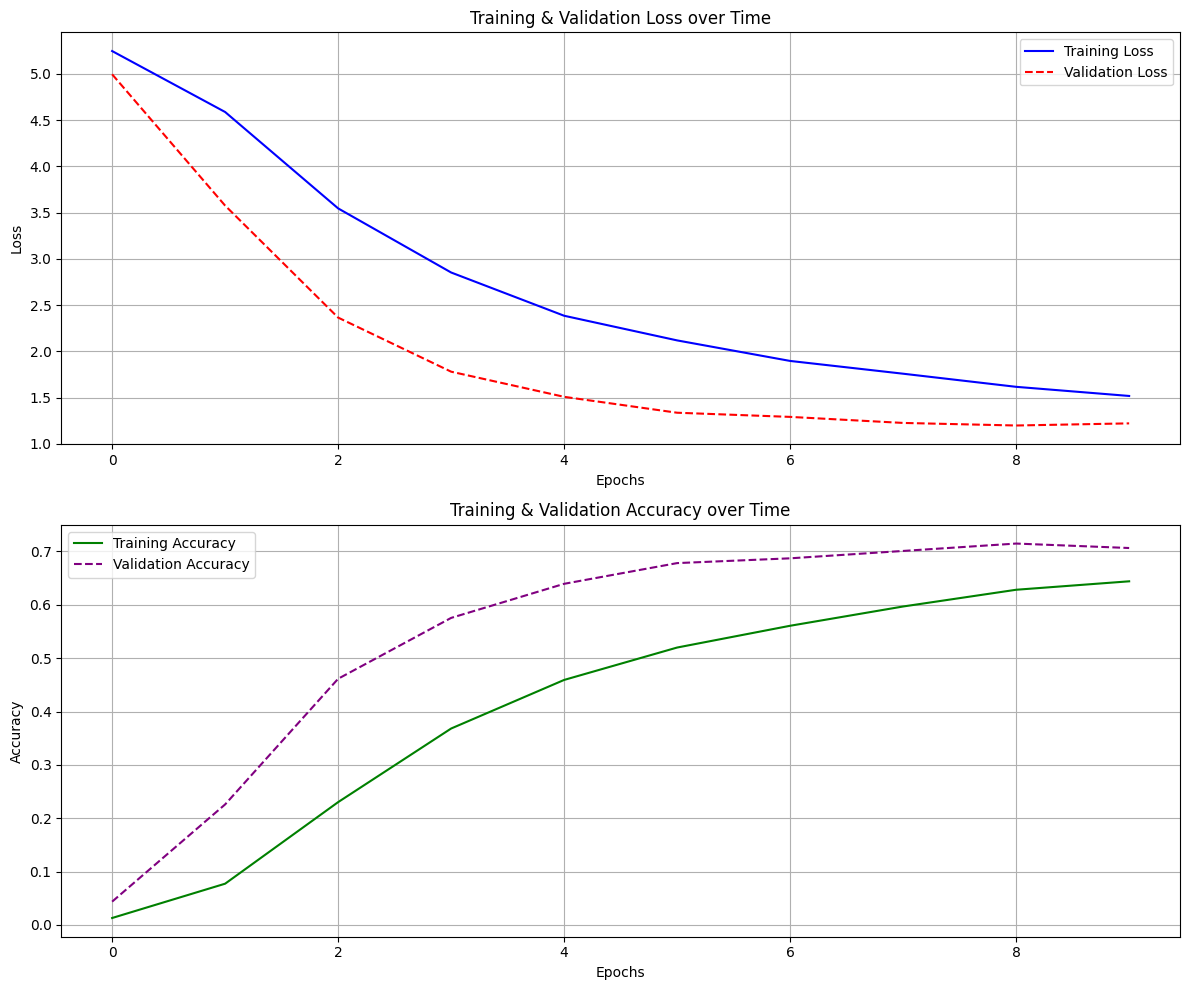

In [8]:
# Setting up the figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plotting Training and Validation Losses
ax1.plot(train_loss_history, color='blue', label='Training Loss')
ax1.plot(val_loss_history, color='red', linestyle='dashed', label='Validation Loss')
ax1.set_title('Training & Validation Loss over Time')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plotting Training and Validation Accuracies
ax2.plot(train_acc_history, color='green', label='Training Accuracy')
ax2.plot(val_acc_history, color='purple', linestyle='dashed', label='Validation Accuracy')
ax2.set_title('Training & Validation Accuracy over Time')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Display the plot
plt.tight_layout()
plt.show()
